# Статистика, DS-поток
## Задание S.9
Задача 1: Исследование p-value и минимальный детектируемый эффект.
▫️ Наличие решения. (70.0)
Баллы: 70.0 / 70.0

Задача 2: Распредление p-value.
▫️ Наличие решения. (50.0)
▫️ Нет ответа на вопрос. Комм. На вопрос: "Чему соответствует доля случаев, в которых p-value меньше 0.05?" ответа нет или он неверный, или он не очень полный(явных слов про мощность нет). (-5.0)
▫️ Хочется увидеть именно в числах доли итераций, где гипотеза отверглась. Комм. Ты правильно понял(а), что доля случаев с p-value<0,05 при условии смещения - это мощность, но нам тут интересно было бы увидеть именно числа. Доля случаев отклонения гипотезы была бы оценкой вероятности ошибки 1 рода, и хорошо, когда она не сильно отличается от заданного уровня значимости. (-7.0)
Баллы: 38.0 / 50.0

Задача 3: Исследование вероятности ошибки 1 рода и мощности для критериев проверки нормальности.
▫️ Пункт 1: наличие решения. (20.0)
▫️ Пункт 2: наличие решения. (15.0)
▫️ Пункт 3: наличие решения. (15.0)
▫️ Нет пояснений, почему мощность Жарка-Бера ниже. Комм. т.к. критерий асимптотический. (-5.0)
Баллы: 45.0 / 50.0

Задача 4: Количество попыток достучаться до бота.
▫️ Наличие решения. (10.0)
▫️ Стоило проверить, что при данных n и np0 критерий хи-квадрат можно применять. (-2.5)
Баллы: 7.5 / 10.0

Задача 5: Проверка генератора в scipy.stats.
▫️ Пункт 1: наличие решения. (15.0)
▫️ Пункт 2: наличие решения. (15.0)
Баллы: 30.0 / 30.0

Сумма: 190.5 / 210.0


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm
from statsmodels.stats.diagnostic import lilliefors

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

_____
### Задача 1.

Вспомним задачу из предыдущего практического задания. Напомним формулировку.

Пусть $X_1, ..., X_n \sim Bern(p)$ &mdash; результаты работы модели на тестовой выборке, где $X_i = 1$, если для $i$-го объекта модель правильно определила класс, а $p$ &mdash; неизвестная вероятность такого события.
Мы хотим проверить гипотезу $\mathsf{H}_0\colon p=1/2$ против альтернативы $\mathsf{H}_1\colon p>1/2$. Нулевая гипотеза означает, что построенный классификатор выдает рандомный ответ, а первая &mdash; что чаще все же выдает верный ответ.

Укажите равномерно наиболее мощный критерий и определите для него p-value.

РНМК: $S = \{\sum\limits_{i=0}^nX_i \geq c_\alpha\}$, $c_\alpha = u_{1-\alpha} + 1$, где $u_{1-\alpha}$ - (1-$\alpha$)-ая квантиль $Bin(n, 0.5)$

p-value: $p(t) = P_0(\sum\limits_{i=0}^nX_i\geq t)$

Проведите несколько экспериментов аналогично предыдущему заданию, дополнив таблицу значениями p-value.

*Замечание:* Пользуйтесь функциями из `scipy.stats`. Внимательно проверьте правильность строгих и нестрогих знаков.

In [3]:
n = 100 # размер выборки
alpha = 0.05 # уровень доверия
sample_sizes = np.arange(n) + 1

# генерируем выборку
sample = sps.bernoulli(0.5).rvs(size=(n,))

c_alpha = sps.binom(n=sample_sizes, p=0.5).ppf(1-alpha) + 1

# считаем статистику 
T = sample.cumsum()

p_value = sps.binom(n=sample_sizes, p=0.5).sf(T - 1)

rejected = (T > c_alpha).astype('int')
rejected

df = pd.DataFrame(data=np.dstack([sample_sizes, T, c_alpha, rejected, p_value]).reshape(n, 5),
                  columns=['n', 'T(X)', 'c_alpha', 'rejected', 'p_value'])
df

,n,T(X),c_alpha,rejected,p_value
0,1.0,0.0,2.0,0.0,1.000000
1,2.0,1.0,3.0,0.0,0.750000
2,3.0,1.0,4.0,0.0,0.875000
3,4.0,1.0,5.0,0.0,0.937500
4,5.0,2.0,5.0,0.0,0.812500
...,...,...,...,...,...
95,96.0,53.0,57.0,0.0,0.179199
96,97.0,54.0,58.0,0.0,0.154967
97,98.0,54.0,58.0,0.0,0.181677
98,99.0,54.0,59.0,0.0,0.210762


Представьте себя заказчиком. Каким должно быть истинное значение $p$, чтобы с точки зрения практики можно было бы считать, что связь между черным котом и неудачей имеется?

Истинное значение p должно хотя бы на 0.1 отличаться от 0.5.

Традиционный вопрос заказчика &mdash; сколько необходимо провести экспериментов? Заказчик не хочет долго ждать, но хочет, чтобы у вашего критерия была достаточная мощность.

Для начала сгенерируйте 10 выборок для двух случаев:
1. $n=5, p=0.75$;
2. $n=10^5, p=0.51$.

В каждом случае в виде таблицы выведите
* реализацию статистики $T(X)$,
* соответствующее p-value,
* 0/1 &mdash; отвергается ли $\mathsf{H}_0$ (выводите 1, если отвергается).

In [4]:
sample_count = 10
alpha = 0.05

In [5]:
n = 5
p = 0.75

sample = sps.bernoulli(p).rvs(size=(sample_count, n))
c_alpha = (sps.binom(n=n, p=0.5).ppf(1-alpha) + 1) * np.ones(sample_count)
T = sample.sum(axis=1)
p_value = sps.binom(n=n, p=0.5).sf(T - 1)
rejected = (T > c_alpha).astype('int')
df = pd.DataFrame(data=np.dstack([n * np.ones(sample_count), T, c_alpha, rejected, p_value]).reshape(sample_count, 5),
                  columns=['n', 'T(X)', 'c_alpha', 'rejected', 'p_value'])
df

,n,T(X),c_alpha,rejected,p_value
0,5.0,4.0,5.0,0.0,0.1875
1,5.0,3.0,5.0,0.0,0.5000
2,5.0,4.0,5.0,0.0,0.1875
3,5.0,4.0,5.0,0.0,0.1875
4,5.0,3.0,5.0,0.0,0.5000
5,5.0,4.0,5.0,0.0,0.1875
6,5.0,4.0,5.0,0.0,0.1875
7,5.0,4.0,5.0,0.0,0.1875
8,5.0,3.0,5.0,0.0,0.5000
9,5.0,3.0,5.0,0.0,0.5000


In [6]:
n = 100000
p = 0.51

sample = sps.bernoulli(p).rvs(size=(sample_count, n))
c_alpha = (sps.binom(n=n, p=0.5).ppf(1-alpha) + 1) * np.ones(sample_count)
T = sample.sum(axis=1)
p_value = sps.binom(n=n, p=0.5).sf(T - 1)
rejected = (T > c_alpha).astype('int')
rejected
df = pd.DataFrame(data=np.dstack([n * np.ones(sample_count), T, c_alpha, rejected, p_value]).reshape(sample_count, 5),
                  columns=['n', 'T(X)', 'c_alpha', 'rejected', 'p_value'])
df

,n,T(X),c_alpha,rejected,p_value
0,100000.0,50857.0,50261.0,1.0,3.028511e-08
1,100000.0,50867.0,50261.0,1.0,2.122309e-08
2,100000.0,50912.0,50261.0,1.0,4.083206e-09
3,100000.0,50951.0,50261.0,1.0,9.181324e-10
4,100000.0,50868.0,50261.0,1.0,2.047735e-08
5,100000.0,51018.0,50261.0,1.0,6.155330e-11
6,100000.0,51084.0,50261.0,1.0,3.617924e-12
7,100000.0,51170.0,50261.0,1.0,6.970098e-14
8,100000.0,50955.0,50261.0,1.0,7.851921e-10
9,100000.0,50861.0,50261.0,1.0,2.628231e-08


**Вывод:** 
Как видим, если размер выборки слишком маленький, то мы не можем отвергнуть значительное отклонение от истинного значения. 
А при очень большом размере выборки мы отвергаем незначительное отклонение с большой уверенностью

Теперь разберемся с тем, как подобрать оптимальный размер выборки.

1. Зафиксируйте значение $p^* > 1/2$, которое на практике обычно называется *минимальным детектируемым эффектом*. Оно должно обладать следующими свойствами.
    - Если истинное $p > p^*$, то такое отклонение от $1/2$ с практической точки зрения признается существенным, то есть новая модель действительно работает лучше.
    - В противном случае отклонение с практической точки зрения признается несущественным.
2. Для некоторых $n$ постройте графики функции мощности критерия при $1/2 < p < 1$ и уровне значимости 0.05.
3. Выберите такое $n^*$, для которого функция мощности дает значение 0.8 при $p^*$.

In [7]:
p_star = 0.6
sample_sizes = np.array([10, 50, 100, 200, 300, 500, 700])

ps = np.linspace(0.5001, 0.9999, 1000) # значения вероятности
c_alpha = sps.binom(sample_sizes[:, None], 0.5).ppf(1 - alpha) + 1

beta = sps.binom(sample_sizes[:, None], ps).sf(c_alpha - 1)


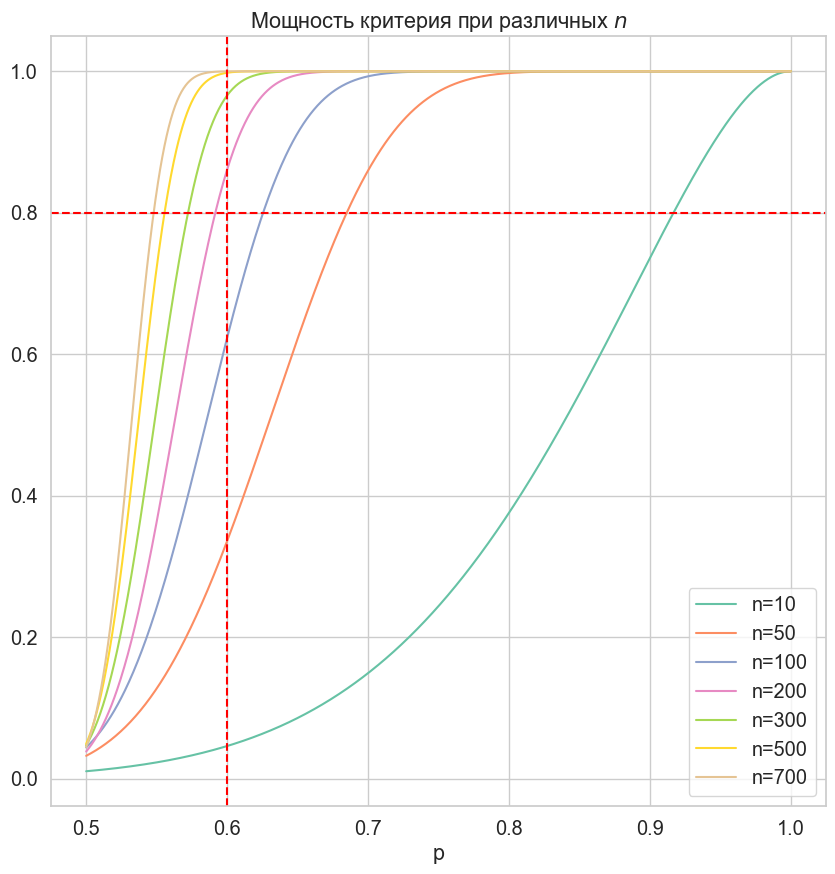

In [8]:
plt.figure(figsize=(10, 10))
for i, n in enumerate(sample_sizes):
    plt.plot(ps, beta[i], label=f'n={n}')

plt.axvline(0.6, linestyle='--', color='red')
plt.axhline(0.8, linestyle='--', color='red')
plt.xlabel('p')
plt.title('Мощность критерия при различных $n$')
plt.legend()

Возьмем n=200

Для выбранного $n^*$ проведите эксперимент, аналогичный проведенным ранее экспериментам, сгенерировав выборки для следующих истинных значений $p$:
 1. $1/2 < p < p^*$;
 2. $p > p^*$.

In [9]:
sample_count = 100
n = 200
p = np.linspace(0.5001, 0.5999, 1000)
alpha = 0.05

sample = sps.bernoulli(p[:, None, None]).rvs(size=(p.shape[0], sample_count, n))
c_alpha = (sps.binom(n=n, p=0.5).ppf(1-alpha) + 1) * np.ones(sample_count)
T = sample.sum(axis=-1)
p_value = sps.binom(n=n, p=0.5).sf(T - 1)
rejected = (T > c_alpha[None, :]).astype('int')
rejects = rejected.sum(axis=-1)
mean_reject_pvalue = np.nanmean(np.where(p_value * rejected, p_value * rejected, np.nan), axis=-1)

C:\Users\rusin\AppData\Local\Temp\ipykernel_20796\1723809538.py:12: RuntimeWarning: Mean of empty slice
  mean_reject_pvalue = np.nanmean(np.where(p_value * rejected, p_value * rejected, np.nan), axis=-1)


Text(0.5, 1.0, 'Средняя уверенность отвержения')

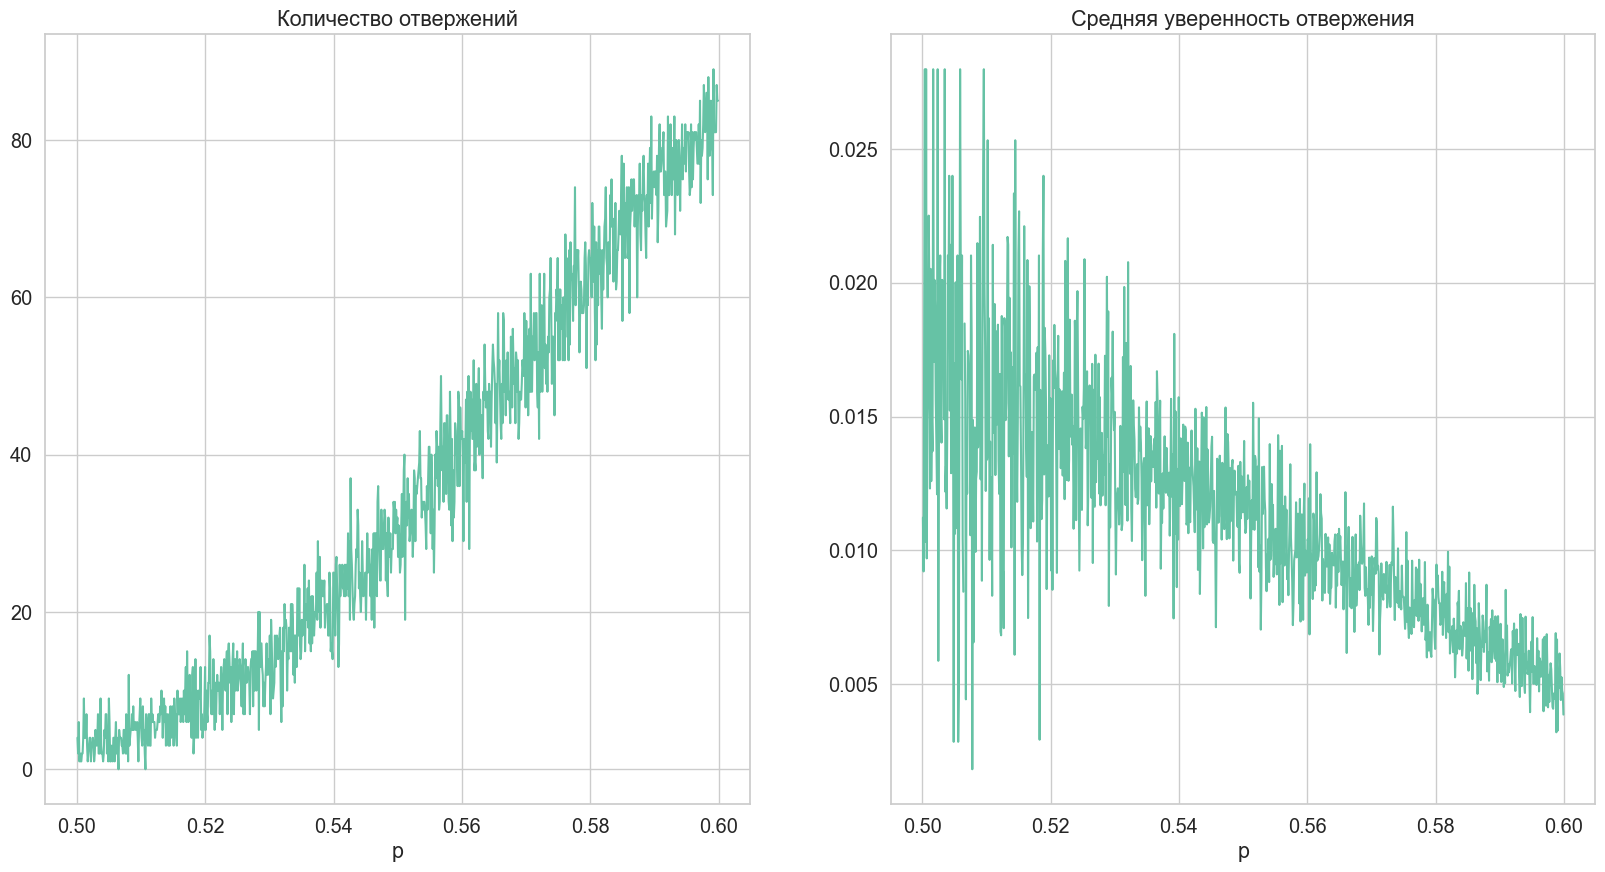

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].plot(p, rejects)
ax[0].set_xlabel('p')
ax[0].set_title('Количество отвержений')
ax[1].plot(p, mean_reject_pvalue)
ax[1].set_xlabel('p')
ax[1].set_title('Средняя уверенность отвержения')

In [11]:
sample_count = 100
n = 200
p = np.linspace(0.6, 0.7, 1000)
alpha = 0.05

sample = sps.bernoulli(p[:, None, None]).rvs(size=(p.shape[0], sample_count, n))
c_alpha = (sps.binom(n=n, p=0.5).ppf(1-alpha) + 1) * np.ones(sample_count)
T = sample.sum(axis=-1)
p_value = sps.binom(n=n, p=0.5).sf(T - 1)
rejected = (T > c_alpha[None, :]).astype('int')
rejects = rejected.sum(axis=-1)
mean_reject_pvalue = np.nanmean(np.where(p_value * rejected, p_value * rejected, np.nan), axis=-1)


Text(0.5, 1.0, 'Средняя уверенность отвержения')

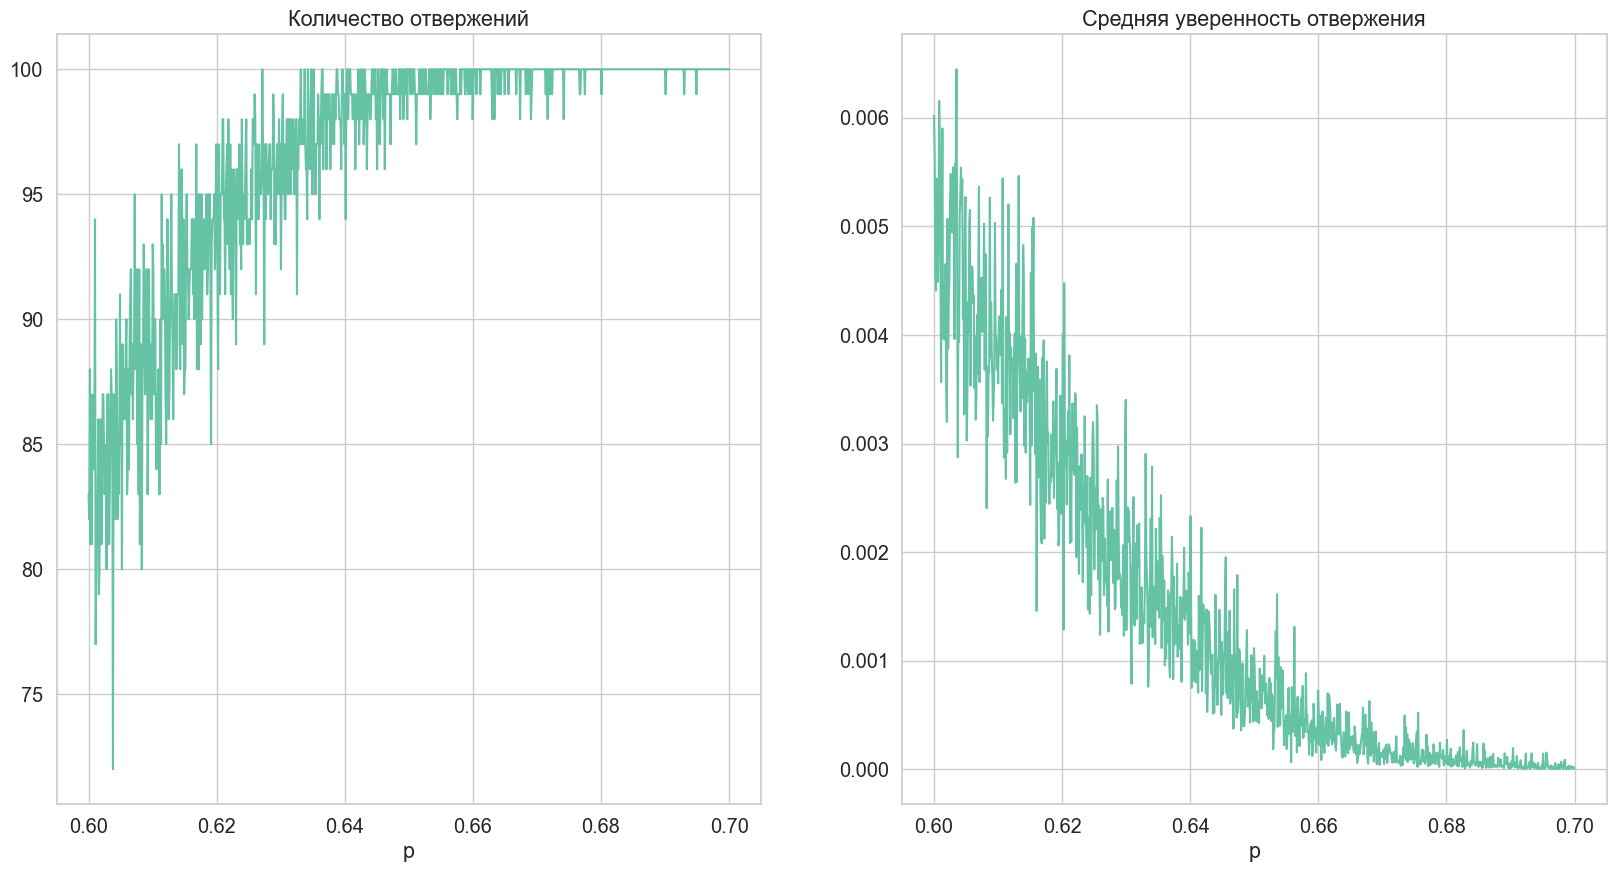

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].plot(p, rejects)
ax[0].set_xlabel('p')
ax[0].set_title('Количество отвержений')
ax[1].plot(p, mean_reject_pvalue)
ax[1].set_xlabel('p')
ax[1].set_title('Средняя уверенность отвержения')

 1. При $1/2 < p < p^*$:
 Видим, что по мере возрастания вероятности, растет количество отвержений, почти линейно, а вот уверенность падает.
 2. $p > p^*$.
 Почти сразу для каждой выборки гипотеза отвергается с большой уверенностью

**Вывод:** 
Размер выборки имеет существенное значение в проведении эксперимента. Иначе можно не детектировать значимые отклонения или наоборот, фиксировать с большой уверенностью незначимые.

_____
### Задача 2.

Рассмотрим выборку $X = (X_{1}, ..., X_{n}) \sim \mathcal{N}(\theta, 1)$. Проверяются гипотезы $\mathsf{H}_0\colon\ \theta = 0\ \ vs.\ \ \mathsf{H}_1\colon\ \theta\ > 0$.

Выпишите равномерно наиболее мощный критерий, который получен в предыдущем домашнем задании.

$S = \{\sum\limits_{i=1}^nX_i > c_\alpha\}$, $c_\alpha = z_{1-\alpha}$ квантиль $\mathcal{N}(0, n)$

p-value: $p(t) = P_0(\sum\limits_{i=1}^nX_i > t)$

На практике если предполагается, что распределение статистики критерия $T(X)$ одинаково и непрерывно, то перед применением критерия можно проверить его на корректность следующим образом.
1. Генерируется множество искусственных выборок в предположении справедливости $\mathsf{H}_0$.
2. По каждой из выборок вычисляется p-value.
3. По всем p-value строится гистограмма, которая визуально проверяется на равномерность.

В AB-тестировании такая процедура часто носит название *AA-тестирование*.

Проверим корректность нашего критерия. Конечно, у нас случай довольно простой, тут и так "все понятно", но стоит отработать навык проверки.
Проведите эксперимент на $10^6$ выборок размера 100 и постройте гистограмму.

Text(0.5, 0, 'p-value')

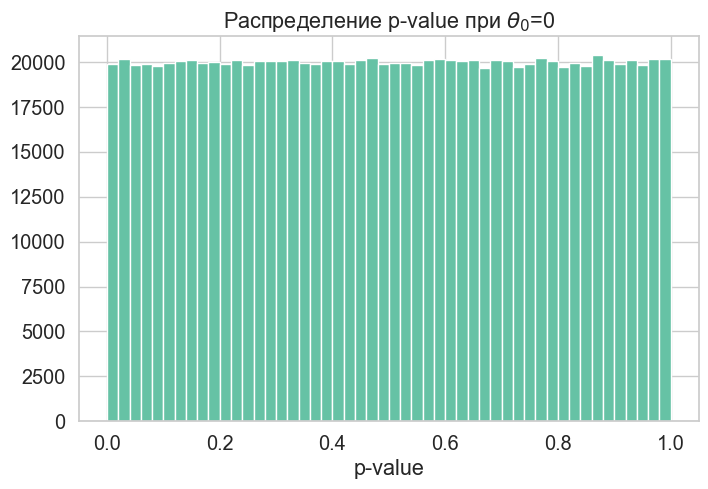

In [13]:
sample_size = 100  # размер выборки
sample_count = 10**6  # количество выборок

samples = sps.norm(0, 1).rvs(size=(sample_count, sample_size))  # множество выборок
Z_stats = samples.sum(axis=-1)  # статистика для каждой из выборок
pvalues = sps.norm(0, np.sqrt(sample_size)).sf(Z_stats)  # p-value для каждой из выборок

plt.figure(figsize=(8, 5))
plt.hist(pvalues, bins=50)
plt.title('Распределение p-value при $\\theta_0$=0')
plt.xlabel('p-value')

Как известно, критерий не меняется при рассмотрении сложной основной гипотезы $\mathsf{H}_0\colon\ \theta \leqslant 0\ \ vs.\ \ \mathsf{H}_1\colon\ \theta\ > 0$.

Повторите эксперимент для истинного $\theta=-0.1$.

Text(0.5, 0, 'p-value')

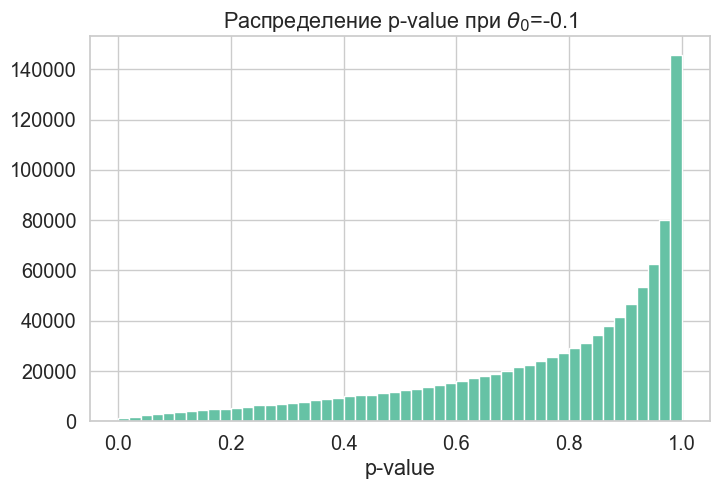

In [14]:
sample_size = 100  # размер выборки
sample_count = 10**6  # количество выборок

samples = sps.norm(-0.1, 1).rvs(size=(sample_count, sample_size))  # множество выборок
Z_stats = samples.sum(axis=-1)  # статистика для каждой из выборок
pvalues = sps.norm(0, np.sqrt(sample_size)).sf(Z_stats)  # p-value для каждой из выборок

plt.figure(figsize=(8, 5))
plt.hist(pvalues, bins=50)
plt.title('Распределение p-value при $\\theta_0$=-0.1')
plt.xlabel('p-value')

Был выбран правосторонний критерий, поэтому мощность получилась низкая на левосторонней альтернативе

*Замечание.* Подобный эффект все равно не дает оснований говорить об уверенности $\mathsf{H}_0$, поскольку критерий может быть недостаточно мощным.

Проверьте, как ведет себя p-value для альтернативы, рассмотрев истинную $\theta=0.1$.

Text(0.5, 0, 'p-value')

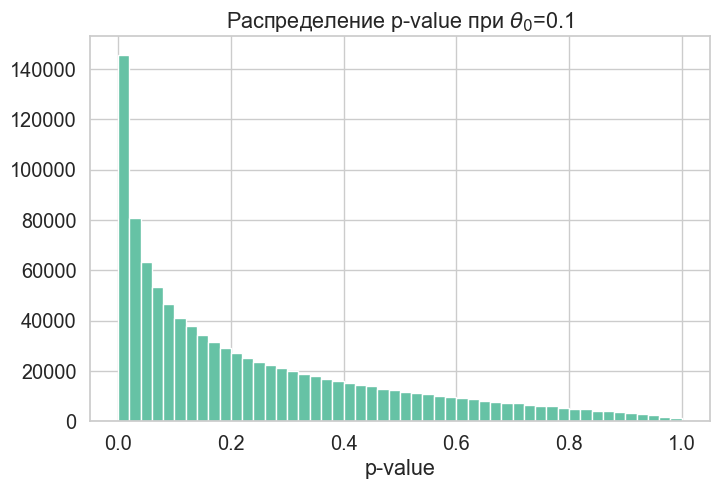

In [15]:
sample_size = 100  # размер выборки
sample_count = 10**6  # количество выборок

samples = sps.norm(0.1, 1).rvs(size=(sample_count, sample_size))  # множество выборок
Z_stats = samples.sum(axis=-1)  # статистика для каждой из выборок
pvalues = sps.norm(0, np.sqrt(sample_size)).sf(Z_stats)  # p-value для каждой из выборок

plt.figure(figsize=(8, 5))
plt.hist(pvalues, bins=50)
plt.title('Распределение p-value при $\\theta_0$=0.1')
plt.xlabel('p-value')

На правосторонней альтернативе видим много отвержений

Чему соответствует доля случаев, в которых p-value меньше 0.05?

Отвержению гипотезы

**Вывод:** 
 Подтвердили на практике, что если гипотеза верна, то p-value распределено равномерно. Проверили, односторонний критерий на левой и правой альтернативах, получили ожидаемый результат.

__________________
### Задача 3.

На лекциях и семинарах были разобраны следующие критерии проверки нормальности:
* Колмогорова;
* Жарка-Бера;
* Шапиро-Уилка.

Cуществует модификация критерия Колмогорова для проверки нормальности — <a href="https://ru.wikipedia.org/wiki/Критерий_Лиллиефорса"> Критерий Лиллиефорса.</a> При решении задачи можете воспользоваться им, например, взяв реализацию из библиотеки `statsmodels`: <a href="https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.lilliefors.html">`statsmodels.stats.diagnostic.lilliefors`</a>, или же применять для конкретной $F_0$ критерий Колмогорова, пример использования которого можно найти в ноутбуке с лекции.

**1.** Данные критерии являются асимптотическими, и их реальное значение уровня значимости может отличаться от желаемого числа $\alpha=0.05$. На семинарах разобран метод оценки реального уровня значимости критерия. Посчитайте реальный уровень значимости этих критериев для размеров выборки от 5 до 100.

*Подсказка:*

In [ ]:
max_sample_size = ...
sample_count = ...
is_reject_<критерий> = np.zeros((max_sample_size, sample_count))

for i in tqdm(range(max_sample_size)):
    for j in range(sample_count):
        sample = ...
        is_reject_<критерий>[i, j] = ...

Ваша реализация:

In [25]:
sample_count = 1000
sample_size = np.arange(5, 101)
sample = sps.norm(0, 1).rvs(size=(sample_count, sample_size[-1]))
is_reject_lil = np.zeros((sample_size[-1], sample_count))
alpha = 0.05

for i in tqdm(sample_size):
    for j in range(sample_count):
        is_reject_lil[i-1, j] = lilliefors(sample[j, :i], 'norm')[1] < alpha

  0%|          | 0/96 [00:00<?, ?it/s]

In [21]:
sample_count = 1000
sample_size = np.arange(5, 101)
sample = sps.norm(0, 1).rvs(size=(sample_count, sample_size[-1]))
is_reject_jb = np.zeros((sample_size[-1], sample_count))
alpha = 0.05

for i in tqdm(sample_size):
    for j in range(sample_count):
        is_reject_jb[i-1, j] = sps.jarque_bera(sample[j, :i])[1] < alpha

  0%|          | 0/96 [00:00<?, ?it/s]

In [22]:
sample_count = 1000
sample_size = np.arange(5, 101)
sample = sps.norm(0, 1).rvs(size=(sample_count, sample_size[-1]))
is_reject_sha = np.zeros((sample_size[-1], sample_count))
alpha = 0.05

for i in tqdm(sample_size):
    for j in range(sample_count):
        is_reject_sha[i-1, j] = sps.shapiro(sample[j, :i])[1] < alpha

  0%|          | 0/96 [00:00<?, ?it/s]

Поясните, почему вы выбрали такое значение `sample_count`.

Искала компромисс между скоростью вычислений и приемлемой ошибкой. Скорость сходимости метода Монте-Карло составляет $\frac{1}{\sqrt{\text{samples\_count}}}$. По-хорошему надо брать $\text{samples\_count} = 10000$, чтобы ошибка была порядка 0.01. Но оно считается слишком долго, поэотому в условиях обучения можно взять и 1000

Нарисуйте на одном графике зависимость реального уровня значимости от размера выборки для каждого критерия. Пунктиром отметьте уровень 0.05. Не забудьте добавить легенду и подписать оси.

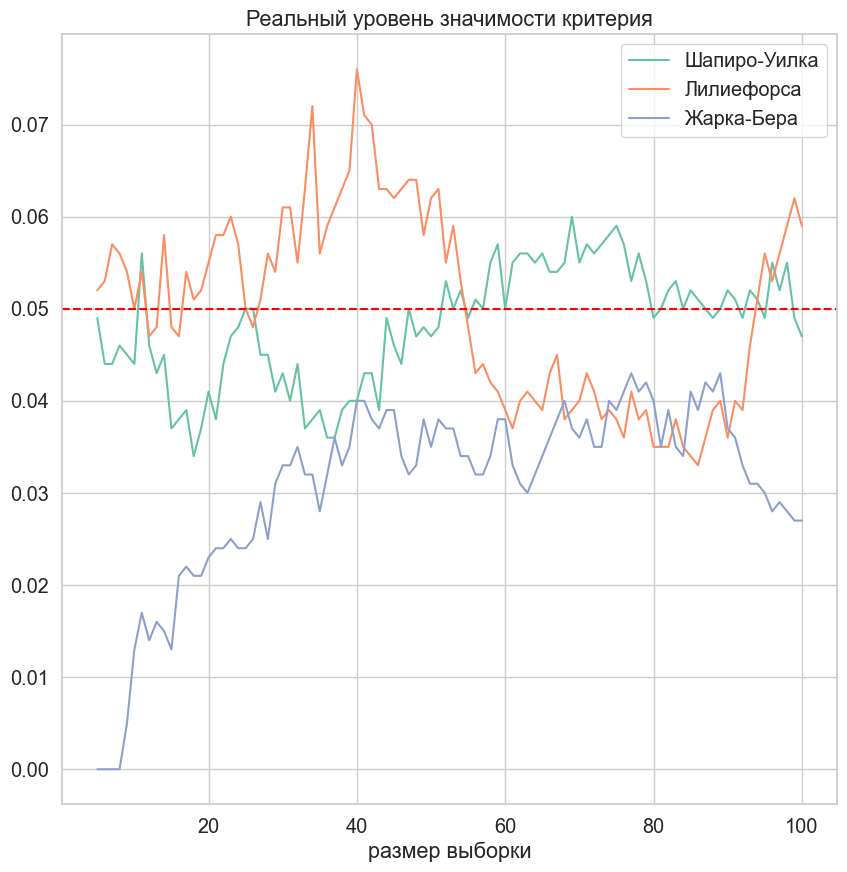

In [23]:
plt.figure(figsize=(10, 10))
plt.plot(np.arange(5, 101), is_reject_sha.sum(axis=-1)[4:] / sample_count, label='Шапиро-Уилка')
plt.plot(np.arange(5, 101), is_reject_lil.sum(axis=-1)[4:] / sample_count, label='Лилиефорса')
plt.plot(np.arange(5, 101), is_reject_jb.sum(axis=-1)[4:] / sample_count, label='Жарка-Бера')
plt.xlabel('размер выборки')
plt.title('Реальный уровень значимости критерия')
plt.axhline(0.05, color='red', linestyle='--')
plt.legend()

Какой можно сделать вывод?

Это асимптотические критерии, поэтому надо смотреть на достаточно большой размер выборки.

1. **Шапиро-Уилк** (зеленая линия):
   - Уровень значимости близок к \( \alpha = 0.05 \) для большинства размеров выборки, что свидетельствует о стабильности и точности данного теста. Он часто пересекает и остается рядом с порогом значимости, что указывает на его хорошую способность поддерживать уровень ошибок I рода.

2. **Лиллиефорс** (оранжевая линия):
   - Тест Лиллиефорса показывает более высокий уровень значимости при небольших размерах выборки и отклонения от уровня \( \alpha = 0.05 \). При увеличении размера выборки его уровень значимости постепенно стабилизируется, но остаётся колеблющимся, что может указывать на повышенную чувствительность к размеру выборки и отклонениям от нормальности.

3. **Жарка-Бера** (синяя линия):
   - Уровень значимости для критерия Жарка-Бера оказывается ниже, чем у других тестов, особенно при небольших размерах выборки, что указывает на его низкую мощность в этих условиях. При увеличении выборки уровень значимости приближается к пороговому значению, но остаётся ниже остальных тестов.

В целом, можно сделать вывод, что критерий Шапиро-Уилк наиболее стабильно поддерживает заданный уровень значимости при различных размерах выборок, в то время как тесты Лиллиефорса и Жарка-Бера демонстрируют колебания, особенно при малых выборках, что может ограничить их точность в таких условиях.

**2.** Аналогичным образом можно вычислять мощность критерия. Вычислите мощности критериев для размеров выборки от 5 до 100, если альтернативная гипотеза заключается в том, что выборка имеет стандартное распределение Коши. Иначе говоря, для критерия $S$ надо приближенно посчитать $\beta_S(\mathsf{P})$, где $\mathsf{P}$ — стандартное распределение Коши.

Нарисуйте на одном графике зависимость мощности критерия от размера выборки для каждого критерия. Не забудьте добавить легенду и подписать оси.


In [26]:
sample_count = 1000
sample_size = np.arange(5, 101)
sample = sps.cauchy(0, 1).rvs(size=(sample_count, sample_size[-1]))
is_reject_lil_beta = np.zeros((sample_size[-1], sample_count))
alpha = 0.05

for i in tqdm(sample_size):
    for j in range(sample_count):
        is_reject_lil_beta[i-1, j] = lilliefors(sample[j, :i], 'norm')[1] < alpha

  0%|          | 0/96 [00:00<?, ?it/s]

In [27]:
sample_count = 1000
sample_size = np.arange(5, 101)
sample = sps.cauchy(0, 1).rvs(size=(sample_count, sample_size[-1]))
is_reject_jb_beta = np.zeros((sample_size[-1], sample_count))
alpha = alpha

for i in tqdm(sample_size):
    for j in range(sample_count):
        is_reject_jb_beta[i-1, j] = sps.jarque_bera(sample[j, :i])[1] < alpha

  0%|          | 0/96 [00:00<?, ?it/s]

In [28]:
sample_count = 1000
sample_size = np.arange(5, 101)
sample = sps.cauchy().rvs(size=(sample_count, sample_size[-1]))
is_reject_sha_beta = np.zeros((sample_size[-1], sample_count))
alpha = alpha

for i in tqdm(sample_size):
    for j in range(sample_count):
        is_reject_sha_beta[i-1, j] = sps.shapiro(sample[j, :i])[1] < alpha

  0%|          | 0/96 [00:00<?, ?it/s]

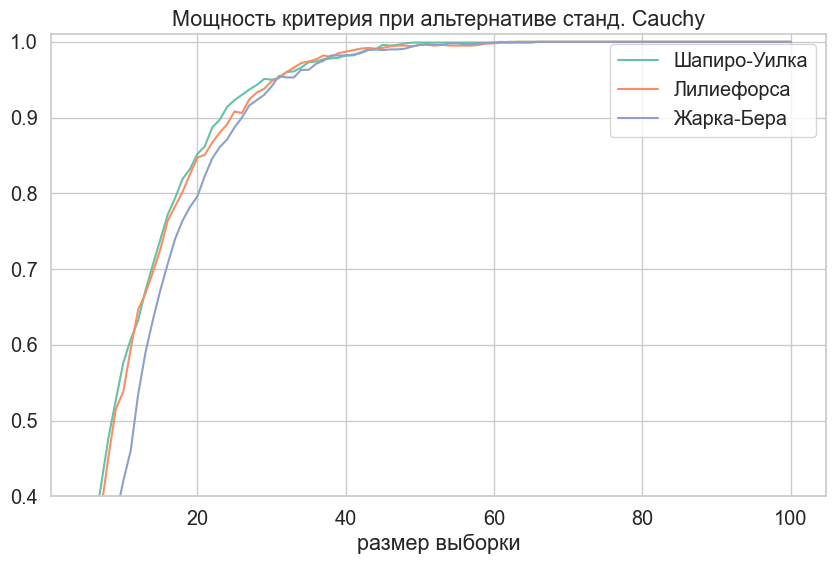

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(5, 101), is_reject_sha_beta.sum(axis=-1)[4:] / sample_count, label='Шапиро-Уилка')
plt.plot(np.arange(5, 101), is_reject_lil_beta.sum(axis=-1)[4:] / sample_count, label='Лилиефорса')
plt.plot(np.arange(5, 101), is_reject_jb_beta.sum(axis=-1)[4:] / sample_count, label='Жарка-Бера')
plt.xlabel('размер выборки')
plt.title('Мощность критерия при альтернативе станд. Cauchy')
plt.ylim(0.4, 1.01)
plt.legend()

Сделайте вывод. Какой критерий является наиболее мощным при данной альтернативе?

Критерии несильно отличаются по мощности. Но если вдаваться в детали, то наиболее мощным является критерий Шапиро-Уилка, чуть менее мощный критерий Лилиефорса, наименее мощный, особенно при малых размерах выборки, критерий Жарка-Бера.

**3.** Распределение Стьюдента является в некотором смысле обобщением нормального распределения (при бесконечном количестве степеней свободы) и распределения Коши (при одной степени свободы).
Посчитайте приближенно мощности критериев для выборки размера 50 если альтернатива заключается в том, что выборка имеет распределение Стьюдента. Поскольку мощность критерия является функцией от распределения из альтернативной гипотезы, вам нужно посчитать функцию. Посчитайте её значения для целых значений степени свободы от 1 до 10.

Нарисуйте на одном графике зависимость мощности критерия от количества степеней свободы для каждого критерия. Не забудьте добавить легенду и подписать оси.

In [33]:
sample_count = 1000
sample_size = 50
sample = sps.t(np.arange(10)[:, None, None] + 1).rvs(size=(10, sample_count, sample_size))
is_reject_sha_t = np.zeros((10, sample_count))
alpha = alpha

for k in tqdm(range(10)):
    for j in range(sample_count):
        is_reject_sha_t[k, j] = sps.shapiro(sample[k, j])[1] < alpha

  0%|          | 0/10 [00:00<?, ?it/s]

In [34]:
sample_count = 1000
sample_size = 50
sample = sps.t(np.arange(10)[:, None, None] + 1).rvs(size=(10, sample_count, sample_size))
is_reject_jb_t = np.zeros((10, sample_count))
alpha = alpha

for k in tqdm(range(10)):
    for j in range(sample_count):
        is_reject_jb_t[k, j] = sps.jarque_bera(sample[k, j])[1] < alpha

  0%|          | 0/10 [00:00<?, ?it/s]

In [35]:
sample_count = 1000
sample_size = 50
sample = sps.t(np.arange(10)[:, None, None] + 1).rvs(size=(10, sample_count, sample_size))
is_reject_lil_t = np.zeros((10, sample_count))
alpha = alpha

for k in tqdm(range(10)):
    for j in range(sample_count):
        is_reject_lil_t[k, j] = lilliefors(sample[k, j])[1] < alpha

  0%|          | 0/10 [00:00<?, ?it/s]

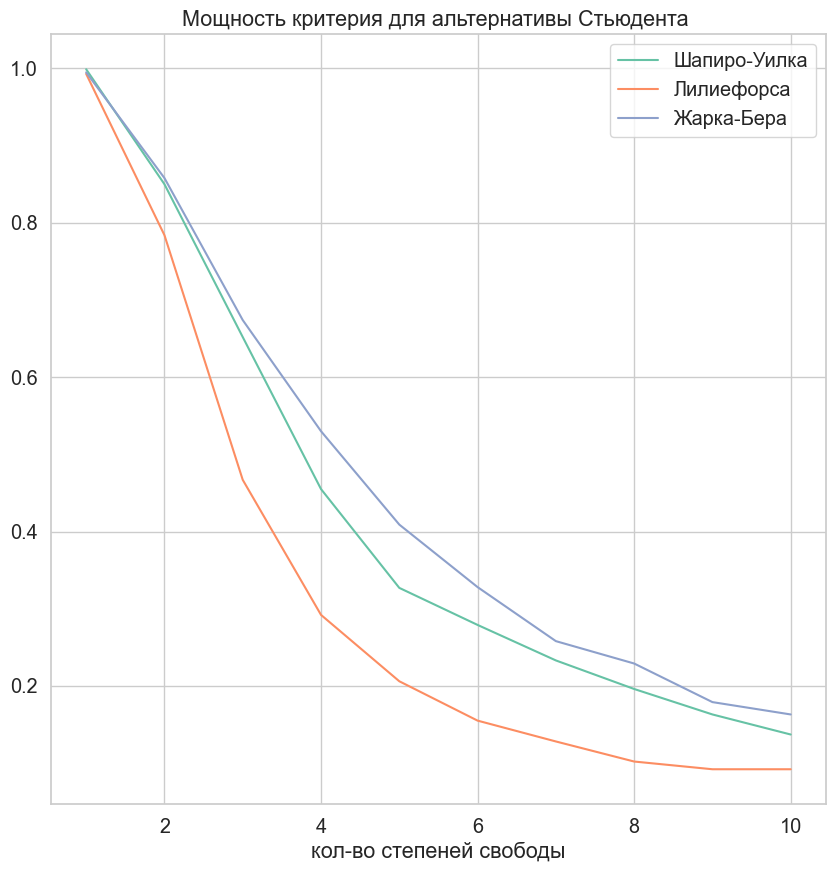

In [36]:
plt.figure(figsize=(10, 10))
plt.plot(np.arange(10)+1, is_reject_sha_t.sum(axis=-1) / sample_count, label='Шапиро-Уилка')
plt.plot(np.arange(10)+1, is_reject_lil_t.sum(axis=-1) / sample_count, label='Лилиефорса')
plt.plot(np.arange(10)+1, is_reject_jb_t.sum(axis=-1) / sample_count, label='Жарка-Бера')
plt.xlabel('кол-во степеней свободы')
plt.title('Мощность критерия для альтернативы Стьюдента ')
plt.legend()

Сделайте вывод относительно мощности критерия при разных распределениях из альтернативы.

С увеличением числа степеней свободы мощность критериев снижается, так как распределение Стьюдента становится всё ближе к нормальному распределению и их различия становятся менее заметными, что приводит к снижению мощности критериев.

___
### Задача 4.
Студенты периодически отправляют запросы в бот. Иногда бот бывает недоступен,
поэтому студенты с некоторыми интервалами повторяют запросы до тех пор, пока
бот не ответит. Известно, что $52$ запроса дошли с первой попытки, $31$ &mdash; со второй, $3$
&mdash; с третьей, а для доставки еще $5$ запросов потребовалось более $4$ попыток. Верно
ли, что бот получает запросы с вероятностью $\frac{2}{3}$?

**Решение:**

H0: бот получает запросы с вероятностью $ p = \frac{2}{3} $, распределение Бернулли. 

Пусть случайная величина $ X $ — количество попыток, требуемых для того, чтобы запрос дошел до бота. Тогда $ X $ имеет геометрическое распределение с параметром $ p = \frac{2}{3} $, и вероятность того, что запрос дойдет до бота с $ k $-ой попытки, равна:
$$
P(X = k) = (1 - p)^{k-1} p.
$$

Для проверки гипотезы воспользуемся критерием согласия $\chi^2$. Рассчитаем теоретические вероятности для каждого случая:

1. **С первой попытки**: $ P(X = 1) = \left( \frac{1}{3} \right)^0 \cdot \frac{2}{3} = \frac{2}{3} $.
2. **Со второй попытки**: $ P(X = 2) = \frac{1}{3} \cdot \frac{2}{3} = \frac{2}{9} $.
3. **С третьей попытки**: $ P(X = 3) = \left( \frac{1}{3} \right)^2 \cdot \frac{2}{3} = \frac{2}{27} $.
4. **С четвертой и более попытки**: $ P(X \geq 4) = 1 - \left( P(X = 1) + P(X = 2) + P(X = 3) \right) $.

Теперь вычислим $ P(X \geq 4) $:
$$
P(X \geq 4) = 1 - \left( \frac{2}{3} + \frac{2}{9} + \frac{2}{27} \right) = \frac{1}{27}.
$$

$ N = 52 + 31 + 3 + 5 = 91 $ — общее количество запросов. Тогда ожидаемое количество запросов для каждого случая при $ p = \frac{2}{3} $ составит:

1. **С первой попытки**: $ E_1 = N \cdot \frac{2}{3} = 91 \cdot \frac{2}{3} = 60.67 $.
2. **Со второй попытки**: $ E_2 = N \cdot \frac{2}{9} = 91 \cdot \frac{2}{9} = 20.22 $.
3. **С третьей попытки**: $ E_3 = N \cdot \frac{2}{27} = 91 \cdot \frac{2}{27} = 6.74 $.
4. **С четвертой и более попытки**: $ E_4 = N \cdot \frac{1}{27} = 91 \cdot \frac{1}{27} = 3.37 $.

Фактические значения:
- С первой попытки: $ O_1 = 52 $.
- Со второй попытки: $ O_2 = 31 $.
- С третьей попытки: $ O_3 = 3 $.
- С четвертой и более попытки: $ O_4 = 5 $.

Теперь вычислим статистику $\chi^2$:
$$
\chi^2 = \sum_{i=1}^4 \frac{(O_i - E_i)^2}{E_i}.
$$
Вычислим значения:
1. Для первой попытки: $ \frac{(52 - 60.67)^2}{60.67} = \frac{(-8.67)^2}{60.67} \approx 1.24 $.
2. Для второй попытки: $ \frac{(31 - 20.22)^2}{20.22} = \frac{(10.78)^2}{20.22} \approx 5.75 $.
3. Для третьей попытки: $ \frac{(3 - 6.74)^2}{6.74} = \frac{(-3.74)^2}{6.74} \approx 2.08 $.
4. Для четвертой и более попытки: $ \frac{(5 - 3.37)^2}{3.37} = \frac{(1.63)^2}{3.37} \approx 0.79 $.

Суммируем значения:
$$
\chi^2 \approx 1.24 + 5.75 + 2.08 + 0.79 = 9.86.
$$

При уровне значимости $ \alpha = 0.05 $ и $ k - 1 = 3 $ степенях свободы критическое значение $\chi^2$ равно приблизительно $ 7.815 $. Поскольку $ 9.86 > 7.815 $, мы отвергаем гипотезу о том, что бот получает запросы с вероятностью $ \frac{2}{3} $.

____
### Задача 5.

С помощью критерия хи-квадрат вам нужно проверить, правильно ли `scipy.stats` генерирует случайные величины.

**1.** Реализуйте критерий для генерации выборки $U\{1, ..., 10\}$, аналогично разобранному на семинаре. Тем самым проверьте, что `sps.randint` действительно генерирует выборку из равномерного распределения.

<...>

**2.** Проверьте, действительно ли код `sps.poisson(mu=5).rvs(size=1000)` генерирует выборку размера 1000 из пуассоновского распределения с параметром 5.

**Указания**
1. Не забудьте учесть условия применимости критерия хи-квадрат;
2. Для вычисления плотности воспользуйтесь `sps.poisson(mu=5).pmf`;
3. Для подсчета количества элементов в разбиении на множества воспользуйтесь `np.unique(sample, return_counts=True)`;
4. Не нужно писать сколь-либо универсальный код, который одним нажатием кнопки проверяет гипотезу с учетом всех условий применимости критерия. Расписывайте код поэтапно, на каждый логический этап свой код в отдельной ячейке для *конкретной* реализации выборки. Так вам проще реализовать, а нам проще проверять.

**Решение:**

1. Равномерное распределение

Возьмем разбиение $B_j=\{j\}$. 

Условия применимости выполнены: 

1. $n=1000 \geq 50$, $np_j^0 = 1000 \cdot 0.1 = 100 \geq 5$.

Text(0.5, 0, 'p-value')

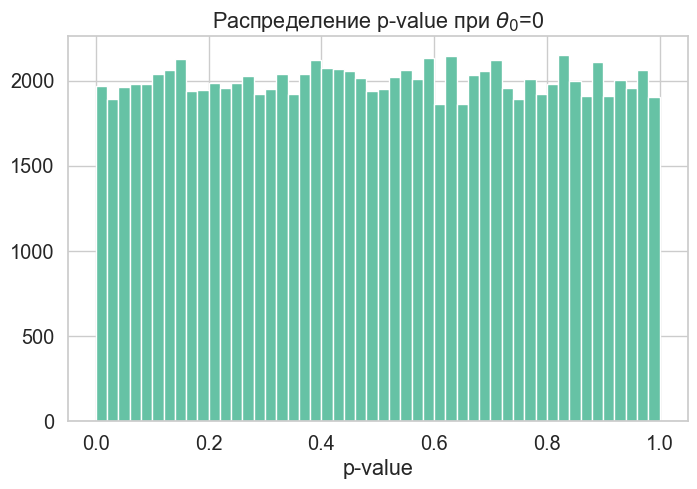

In [17]:
size = 1000
samples_count = 100000
sample = sps.randint(1, 11).rvs(size=(samples_count, size))

res = [sps.chisquare(np.unique(sample[i], return_counts=True)[1], np.ones(10) * 100) for i in range(samples_count)]
stat = []
pv = []
for r in res:
    stat.append(r[0])
    pv.append(r[1])

plt.figure(figsize=(8, 5))
plt.hist(pv, bins=50)
plt.title('Распределение p-value при $\\theta_0$=0')
plt.xlabel('p-value')

Видим, что p-value распределено равномерно, значит, скорее всего, гипотеза верна. 

Либо критерий может быть не очень мощным, однако у нас довольно большое количество сэмплирований, то есть критических p-value все равно должно быть гораздо больше.

2. Распределение Пуассона

Возьмем разбиение 
$B_j=\{j\}, j\in\overline{0, 8}$; 

$B_9=\{x| x \geq 9\}$. 

Условия применимости выполнены: 

1. $n=1000 \geq 50$, $np_j^0 \geq 1000 \cdot 0.006 = 6 \geq 5$.

In [18]:
size = 1000
samples_count = 100000
mu = 5

# Генерируем выборки
sample = sps.poisson(mu=mu).rvs(size=(samples_count, size))

# Определяем вероятности для значений от 0 до 8 и для остальных (>= 9)
p = sps.poisson(mu=mu).pmf(np.arange(9))
p = np.concatenate([p, [1 - p.sum()]])

# Вычисляем значения p-value для каждого набора данных
p_values = []
for i in range(samples_count):
    unique, counts = np.unique(sample[i], return_counts=True)
    count_above_8 = counts[unique >= 9].sum()
    
    observed = np.concatenate([counts[unique < 9], [count_above_8]])
    expected = p * size
    
    try:
        chi2_stat, p_value = sps.chisquare(observed, expected)
        p_values.append(p_value)
    except ValueError:
        continue


Text(0.5, 0, 'p-value')

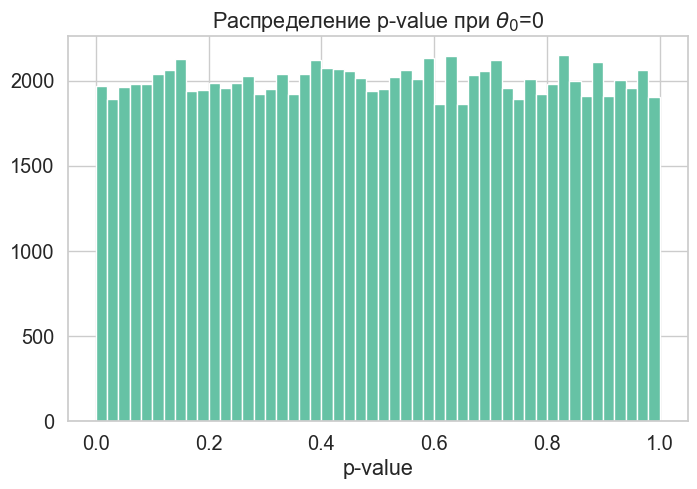

In [19]:
plt.figure(figsize=(8, 5))
plt.hist(pv, bins=50)
plt.title('Распределение p-value при $\\theta_0$=0')
plt.xlabel('p-value')

Снова получаем равномерное распределение p-value то есть гипотеза скорее верна.

**Вывод:**

Не смогли отвергнуть гипотезу о том, что библиотека sps хорошо генерирует случайные величины из равномерного и пуассоновского распределений